# Test: Fixed Vertical 2×1 Arrays Configuration

This notebook tests the antenna clustering algorithms using a **fixed configuration** consisting only of vertical 2×1 arrays.

**Configuration:**
- Cluster type: Vertical 2×1 `[[0, 0], [0, 1]]`
- Distance Z (vertical): 0.7λ
- Distance Y (horizontal): 0.5λ

**Purpose:** Verify results match theoretical maximum for the "all vertical 2×1" setup.

In [1]:
# Installa dipendenze se su Colab
import sys
if 'google.colab' in sys.modules:
    print("Running on Colab - installing dependencies...")
    %pip install numpy scipy matplotlib cupy-cuda12x -q
    print("Done! CuPy installed for GPU acceleration.")

In [2]:
import numpy as np
import time
from dataclasses import dataclass, field
from typing import List, Tuple, Dict, Optional
from scipy.interpolate import griddata, LinearNDInterpolator
from scipy.spatial import Delaunay
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# OPT: Try to import CuPy for GPU acceleration
try:
    import cupy as cp
    GPU_AVAILABLE = cp.cuda.is_available()
    if GPU_AVAILABLE:
        print("[OK] GPU disponibile - CuPy attivo")
        xp = cp  # Use CuPy for array operations
    else:
        print("[WARN] CuPy installato ma GPU non disponibile - uso CPU")
        xp = np
        GPU_AVAILABLE = False
except ImportError:
    print("[INFO] CuPy non installato - uso CPU (installa con: pip install cupy-cuda12x)")
    xp = np
    GPU_AVAILABLE = False

print("Import completati!")

[INFO] CuPy non installato - uso CPU (installa con: pip install cupy-cuda12x)
Import completati!


In [3]:
@dataclass
class LatticeConfig:
    """Configurazione lattice array"""
    Nz: int  # Number of rows
    Ny: int  # Number of columns
    dist_z: float  # antenna distance on z axis [times lambda]
    dist_y: float  # antenna distance on y axis [times lambda]
    lattice_type: int = 1  # 1=Rectangular

@dataclass
class SystemConfig:
    """Parametri sistema"""
    freq: float  # [Hz]
    lambda_: float = field(init=False)
    beta: float = field(init=False)
    azi0: float = 0.0
    ele0: float = 0.0
    dele: float = 0.5
    dazi: float = 0.5

    def __post_init__(self):
        self.lambda_ = 3e8 / self.freq
        self.beta = 2 * np.pi / self.lambda_

@dataclass
class MaskConfig:
    """Parametri maschera SLL"""
    elem: float = 30.0
    azim: float = 60.0
    SLL_level: float = 20.0
    SLLin: float = 15.0

@dataclass
class ElementPatternConfig:
    """Configurazione pattern elemento"""
    P: int = 1
    Gel: float = 5.0
    load_file: int = 0

@dataclass
class SimulationConfig:
    """Parametri simulazione"""
    Niter: int = 1000
    Cost_thr: int = 1000

@dataclass
class ClusterConfig:
    """Configurazione cluster"""
    Cluster_type: List[np.ndarray] = field(default_factory=list)
    rotation_cluster: int = 0

    def __post_init__(self):
        if not self.Cluster_type:
            self.Cluster_type = [np.array([[0, 0], [0, 1]])]

print("Classi di configurazione definite!")

Classi di configurazione definite!


In [4]:
class AntennaArray:
    """Classe per array di antenne con clustering"""

    def __init__(self, lattice: LatticeConfig, system: SystemConfig, 
                 mask: MaskConfig, eef_config: Optional[ElementPatternConfig] = None):
        self.lattice = lattice
        self.system = system
        self.mask = mask
        self.eef_config = eef_config or ElementPatternConfig()
        self.Nel = lattice.Nz * lattice.Ny

        self._compute_lattice_vectors()
        self._generate_lattice()
        self._generate_polar_coordinates()
        self._generate_element_pattern()
        self._generate_mask()

    def _compute_lattice_vectors(self):
        lambda_ = self.system.lambda_
        dz = self.lattice.dist_z * lambda_
        dy = self.lattice.dist_y * lambda_
        self.x1 = np.array([dy, 0.0])
        self.x2 = np.array([0.0, dz])

    def _generate_lattice(self):
        Nz = self.lattice.Nz
        Ny = self.lattice.Ny

        if Nz % 2 == 1:
            M = np.arange(-(Nz - 1) / 2, (Nz - 1) / 2 + 1)
        else:
            M = np.arange(-Nz / 2 + 1, Nz / 2 + 1)

        if Ny % 2 == 1:
            N = np.arange(-(Ny - 1) / 2, (Ny - 1) / 2 + 1)
        else:
            N = np.arange(-Ny / 2 + 1, Ny / 2 + 1)

        self.NN, self.MM = np.meshgrid(N, M)
        dz = self.x2[1]
        dy = self.x1[0]
        DELTA = max(self.x2[0], self.x1[1])

        self.Y = self.NN * dy
        self.Z = self.MM * dz
        self.Y[1::2, :] = self.Y[1::2, :] + DELTA

        self.y_vec = self.Y.flatten()
        self.z_vec = self.Z.flatten()

    def _generate_polar_coordinates(self):
        dele = self.system.dele
        dazi = self.system.dazi
        elem = self.mask.elem
        azim = self.mask.azim

        self.ele = np.arange(-elem, elem + dele, dele)
        self.azi = np.arange(-azim, azim + dazi, dazi)

        self.AZI, self.ELE = np.meshgrid(self.azi, self.ele)

        azir = np.deg2rad(self.azi)
        eler = np.deg2rad(self.ele)
        AZIR, ELER = np.meshgrid(azir, eler)

        self.Ky = self.system.beta * np.sin(AZIR) * np.cos(ELER)
        self.Kz = self.system.beta * np.sin(ELER)

    def _generate_element_pattern(self):
        P = self.eef_config.P
        Gel = self.eef_config.Gel
        load_file = self.eef_config.load_file

        if load_file == 0:
            AZIR = np.deg2rad(self.AZI)
            ELER = np.deg2rad(self.ELE)

            if P == 1:
                EEF = np.cos(ELER) * np.cos(AZIR)
                EEF = np.maximum(EEF, 1e-10)
            else:
                EEF = np.ones_like(AZIR)

            EEF_dB = 10 * np.log10(EEF**2)
            self.RPE_ele_max = Gel
            self.EEF_dB = EEF_dB + Gel
        else:
            self.EEF_dB = np.zeros_like(self.AZI)
            self.RPE_ele_max = 0

    def _generate_mask(self):
        ele0 = self.system.ele0
        azi0 = self.system.azi0
        SLL_level = self.mask.SLL_level
        SLLin = self.mask.SLLin

        L_ele = 8.0
        L_azi = 8.0

        mask_ele = (self.ELE >= ele0 - L_ele) & (self.ELE <= ele0 + L_ele)
        mask_azi = (self.AZI >= azi0 - L_azi) & (self.AZI <= azi0 + L_azi)
        self.FoV_mask = mask_ele & mask_azi

        self.SLL_mask_out = np.full_like(self.AZI, -SLL_level, dtype=float)
        self.SLL_mask_in = np.full_like(self.AZI, -SLLin, dtype=float)

    def index_to_position_cluster(self, Cluster: List[np.ndarray], 
                                   ElementExc: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        Ntrans = len(Cluster)
        max_size = max(c.shape[0] for c in Cluster)

        Yc = np.full((max_size, Ntrans), np.nan)
        Zc = np.full((max_size, Ntrans), np.nan)
        Ac = np.full((max_size, Ntrans), np.nan)

        for k, cluster in enumerate(Cluster):
            for j, (n_idx, m_idx) in enumerate(cluster):
                y_idx = np.where(self.NN[0, :] == n_idx)[0]
                z_idx = np.where(self.MM[:, 0] == m_idx)[0]

                if len(y_idx) > 0 and len(z_idx) > 0:
                    y_idx = y_idx[0]
                    z_idx = z_idx[0]
                    Yc[j, k] = self.Y[z_idx, y_idx]
                    Zc[j, k] = self.Z[z_idx, y_idx]
                    Ac[j, k] = ElementExc[z_idx, y_idx]

        return Yc, Zc, Ac

    def coefficient_evaluation(self, Zc_m: np.ndarray, Yc_m: np.ndarray, 
                                Lsub: np.ndarray) -> np.ndarray:
        azi0_rad = np.deg2rad(self.system.azi0)
        ele0_rad = np.deg2rad(self.system.ele0)
        beta = self.system.beta

        ky0 = beta * np.sin(azi0_rad) * np.cos(ele0_rad)
        kz0 = beta * np.sin(ele0_rad)

        c0 = Lsub * np.exp(1j * (ky0 * Yc_m + kz0 * Zc_m))
        return c0

    def kernel1_rpe(self, Lsub: np.ndarray, Ac: np.ndarray, 
                    Yc: np.ndarray, Zc: np.ndarray, 
                    c0: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        Ntrans = len(Lsub)
        Nele = len(self.ele)
        Nazi = len(self.azi)

        KerFF_sub = np.zeros((Nele, Nazi, Ntrans), dtype=complex)

        for k in range(Ntrans):
            L = Lsub[k]
            for j in range(L):
                if not np.isnan(Yc[j, k]):
                    phase = self.Ky * Yc[j, k] + self.Kz * Zc[j, k]
                    KerFF_sub[:, :, k] += Ac[j, k] * np.exp(1j * phase)

        FF_tot = np.zeros((Nele, Nazi), dtype=complex)
        for k in range(Ntrans):
            FF_tot += c0[k] * KerFF_sub[:, :, k]

        EEF_lin = 10 ** (self.EEF_dB / 10)
        FF_norm = np.abs(FF_tot) ** 2 * EEF_lin

        FF_norm_dB = 10 * np.log10(FF_norm + 1e-30)
        FF_max = np.max(FF_norm)
        FF_I_dB = 10 * np.log10(FF_norm / FF_max + 1e-30)

        return FF_norm_dB, FF_I_dB, KerFF_sub, FF_norm

    def compute_cost_function(self, FF_I_dB: np.ndarray) -> int:
        out_mask = ~self.FoV_mask
        violations_out = FF_I_dB[out_mask] - self.SLL_mask_out[out_mask]
        Cm_out = int(np.sum(violations_out[violations_out > 0]))

        in_mask = self.FoV_mask
        violations_in = FF_I_dB[in_mask] - self.SLL_mask_in[in_mask]
        Cm_in = int(np.sum(violations_in[violations_in > 0]))

        boresight_idx = np.unravel_index(np.argmax(FF_I_dB * self.FoV_mask), FF_I_dB.shape)
        boresight_val = FF_I_dB[boresight_idx]
        if boresight_val < -0.5:
            Cm_in += int(abs(boresight_val) * 10)

        return Cm_out + Cm_in

    def compute_sll(self, FF_I_dB: np.ndarray, G_boresight: float) -> Tuple[float, float]:
        out_mask = ~self.FoV_mask
        in_mask = self.FoV_mask

        ff_out = FF_I_dB.copy()
        ff_out[in_mask] = -np.inf
        sll_out = np.max(ff_out)

        ff_in = FF_I_dB.copy()
        ff_in[out_mask] = -np.inf
        main_lobe_mask = ff_in > -3
        ff_in[main_lobe_mask] = -np.inf
        sll_in = np.max(ff_in)

        return sll_in, sll_out

    def evaluate_clustering(self, Cluster: List[np.ndarray], 
                            ElementExc: Optional[np.ndarray] = None) -> Dict:
        if ElementExc is None:
            ElementExc = np.ones((self.lattice.Nz, self.lattice.Ny))

        Yc, Zc, Ac = self.index_to_position_cluster(Cluster, ElementExc)
        Ntrans = len(Cluster)

        Lsub = np.array([c.shape[0] for c in Cluster])
        Zc_m = np.array([np.nanmean(Zc[:Lsub[k], k]) for k in range(Ntrans)])
        Yc_m = np.array([np.nanmean(Yc[:Lsub[k], k]) for k in range(Ntrans)])

        c0 = self.coefficient_evaluation(Zc_m, Yc_m, Lsub)
        FF_norm_dB, FF_I_dB, KerFF_sub, FF_norm = self.kernel1_rpe(Lsub, Ac, Yc, Zc, c0)

        Cm = self.compute_cost_function(FF_I_dB)
        
        # Calcola G_boresight prima di compute_sll
        G_boresight = self.RPE_ele_max + 10 * np.log10(np.sum(Lsub))
        sll_in, sll_out = self.compute_sll(FF_I_dB, G_boresight)

        max_idx = np.unravel_index(np.argmax(FF_I_dB), FF_I_dB.shape)
        theta_max = self.ele[max_idx[0]]
        phi_max = self.azi[max_idx[1]]

        Iele = np.argmin(np.abs(self.ele - self.system.ele0))
        Iazi = np.argmin(np.abs(self.azi - self.system.azi0))

        SL_maxpointing = G_boresight - FF_I_dB[max_idx]
        SL_theta_phi = G_boresight - FF_I_dB[Iele, Iazi]

        return {
            "Yc": Yc, "Zc": Zc, "Ac": Ac, "Yc_m": Yc_m, "Zc_m": Zc_m,
            "Lsub": Lsub, "Ntrans": Ntrans, "c0": c0,
            "FF_norm_dB": FF_norm_dB, "FF_I_dB": FF_I_dB, "KerFF_sub": KerFF_sub,
            "Cm": Cm, "sll_in": sll_in, "sll_out": sll_out,
            "theta_max": theta_max, "phi_max": phi_max,
            "SL_maxpointing": SL_maxpointing, "SL_theta_phi": SL_theta_phi,
            "G_boresight": G_boresight,
        }

print("Classe AntennaArray definita!")

Classe AntennaArray definita!


In [5]:
class FullSubarraySetGeneration:
    """Genera il set completo di subarray possibili"""

    def __init__(self, cluster_type: np.ndarray, lattice: LatticeConfig,
                 NN: np.ndarray, MM: np.ndarray, rotation_cluster: int = 0):
        self.cluster_type = np.atleast_2d(cluster_type)
        self.lattice = lattice
        self.NN = NN
        self.MM = MM
        self.rotation_cluster = rotation_cluster
        self.S, self.Nsub = self._generate()

    def _generate(self):
        B = self.cluster_type
        A = np.sum(B, axis=0)
        M = self.MM.flatten()
        N = self.NN.flatten()

        if A[0] == 0:
            step_M = B.shape[0]
            step_N = 1
        elif A[1] == 0:
            step_N = B.shape[0]
            step_M = 1
        else:
            step_M = 1
            step_N = 1

        S = []
        min_M, max_M = int(np.min(M)), int(np.max(M))
        min_N, max_N = int(np.min(N)), int(np.max(N))

        for kk in range(min_M, max_M + 1, step_M):
            for hh in range(min_N, max_N + 1, step_N):
                Bshift = B.copy()
                Bshift[:, 0] = B[:, 0] + hh
                Bshift[:, 1] = B[:, 1] + kk

                check = not np.any(
                    (Bshift[:, 0] > max_N) | (Bshift[:, 0] < min_N) |
                    (Bshift[:, 1] > max_M) | (Bshift[:, 1] < min_M)
                )

                if check:
                    S.append(Bshift)

        return S, len(S)

print("Classe FullSubarraySetGeneration definita!")

Classe FullSubarraySetGeneration definita!


## Configuration: Vertical 2×1 Arrays with 0.7λ and 0.5λ distances

In [6]:
# ============================================================
# CONFIGURAZIONE TEST: Vertical 2x1 con distanze 0.7λ e 0.5λ
# ============================================================

SEED = 42  # Random seed per riproducibilita

# Configurazione array con distanze specificate
lattice = LatticeConfig(
    Nz=16, 
    Ny=16, 
    dist_z=0.7,   # 0.7λ - vertical spacing
    dist_y=0.5,   # 0.5λ - horizontal spacing
    lattice_type=1
)

system = SystemConfig(freq=29.5e9, azi0=0, ele0=0, dele=0.5, dazi=0.5)
mask = MaskConfig(elem=30, azim=60, SLL_level=20, SLLin=15)
eef = ElementPatternConfig(P=1, Gel=5, load_file=0)

# Cluster type: Vertical 2x1 - [[0,0], [0,1]] significa stesso y (0), z diversi (0 e 1)
cluster_config = ClusterConfig(Cluster_type=[np.array([[0, 0], [0, 1]])])

print("="*70)
print("CONFIGURAZIONE TEST: VERTICAL 2x1 ARRAYS")
print("="*70)
print(f"  Array: {lattice.Nz}x{lattice.Ny} = {lattice.Nz * lattice.Ny} elementi")
print(f"  Distanza Z (verticale): {lattice.dist_z}λ")
print(f"  Distanza Y (orizzontale): {lattice.dist_y}λ")
print(f"  Frequenza: {system.freq/1e9:.1f} GHz")
print(f"  Cluster type: Vertical 2x1 [[0,0], [0,1]]")
print("="*70)

CONFIGURAZIONE TEST: VERTICAL 2x1 ARRAYS
  Array: 16x16 = 256 elementi
  Distanza Z (verticale): 0.7λ
  Distanza Y (orizzontale): 0.5λ
  Frequenza: 29.5 GHz
  Cluster type: Vertical 2x1 [[0,0], [0,1]]


In [7]:
# Inizializza array antenna
print("Inizializzazione array antenna...")
array = AntennaArray(lattice, system, mask, eef)
print("Array inizializzato!")

Inizializzazione array antenna...
Array inizializzato!


## Generate Fixed Full-Tiling Configuration

Create a configuration where **ALL** valid vertical 2×1 subarrays are selected (full tiling without gaps).

In [8]:
# ============================================================
# GENERA CONFIGURAZIONE FISSA: TUTTI I VERTICAL 2x1 SUBARRAYS
# ============================================================

# Genera tutti i possibili subarrays verticali 2x1
cluster_type = np.array([[0, 0], [0, 1]])  # Vertical 2x1
gen = FullSubarraySetGeneration(
    cluster_type, 
    array.lattice, 
    array.NN, 
    array.MM,
    rotation_cluster=0
)

print(f"Generati {gen.Nsub} subarrays verticali 2x1 possibili")

# Per la configurazione "all vertical 2x1", selezioniamo TUTTI i subarrays
# che formano un tiling completo (non sovrapposti)
# Con un array 16x16 e cluster verticali 2x1, possiamo avere 16 colonne * 8 righe di cluster = 128 cluster

# Crea tiling completo: per ogni colonna, seleziona cluster a righe alternate (0,2,4,...)
all_clusters_fixed = []
M_vals = sorted(set(array.MM.flatten().astype(int)))
N_vals = sorted(set(array.NN.flatten().astype(int)))

# Per il tiling completo con cluster verticali 2x1:
# - Ogni cluster occupa 2 righe consecutive (m, m+1)
# - Selezioniamo cluster a partire da righe pari
for n in N_vals:  # Per ogni colonna
    for m in M_vals[::2]:  # Per ogni riga pari (0, 2, 4, ...)
        if m + 1 in M_vals:  # Assicurati che la riga successiva esista
            cluster = np.array([[n, m], [n, m + 1]])
            all_clusters_fixed.append(cluster)

print(f"\nConfigurazione fissa (full tiling): {len(all_clusters_fixed)} cluster verticali 2x1")
print(f"Elementi totali coperti: {len(all_clusters_fixed) * 2}")

Generati 128 subarrays verticali 2x1 possibili

Configurazione fissa (full tiling): 128 cluster verticali 2x1
Elementi totali coperti: 256


In [9]:
# ============================================================
# VALUTAZIONE CONFIGURAZIONE FISSA
# ============================================================

print("="*70)
print("VALUTAZIONE CONFIGURAZIONE FISSA (ALL VERTICAL 2x1)")
print("="*70)

result_fixed = array.evaluate_clustering(all_clusters_fixed)

print(f"\nRISULTATI CONFIGURAZIONE FISSA:")
print("-"*50)
print(f"  Numero cluster (Ntrans):    {result_fixed['Ntrans']}")
print(f"  Elementi totali (Nel):      {np.sum(result_fixed['Lsub'])}")
print(f"  Cost Function (Cm):         {result_fixed['Cm']}")
print(f"  SLL out FoV (dB):           {result_fixed['sll_out']:.2f}")
print(f"  SLL in FoV (dB):            {result_fixed['sll_in']:.2f}")
print(f"  G_boresight (dBi):          {result_fixed['G_boresight']:.2f}")
print(f"  Max pointing direction:     θ={result_fixed['theta_max']:.1f}°, φ={result_fixed['phi_max']:.1f}°")
print(f"  Scan Loss (max pointing):   {result_fixed['SL_maxpointing']:.2f} dB")
print(f"  Scan Loss (θ0, φ0):         {result_fixed['SL_theta_phi']:.2f} dB")
print("="*70)

VALUTAZIONE CONFIGURAZIONE FISSA (ALL VERTICAL 2x1)



RISULTATI CONFIGURAZIONE FISSA:
--------------------------------------------------
  Numero cluster (Ntrans):    128
  Elementi totali (Nel):      256
  Cost Function (Cm):         7150
  SLL out FoV (dB):           -13.32
  SLL in FoV (dB):            -3.08
  G_boresight (dBi):          29.08
  Max pointing direction:     θ=0.0°, φ=0.0°
  Scan Loss (max pointing):   29.08 dB
  Scan Loss (θ0, φ0):         29.08 dB


## Plotting Functions (from original notebook)

In [10]:
# ============================================================
# FUNZIONI DI PLOTTING (dal notebook originale)
# ============================================================

def extract_lobe_metrics(FF_I_dB, azi, ele, azi0, ele0, G_boresight=None):
    """
    Extract lobe performance metrics from far-field pattern.
    """
    # Find boresight indices
    ele_idx = np.argmin(np.abs(ele - ele0))
    azi_idx = np.argmin(np.abs(azi - azi0))
    
    # Extract cuts
    ele_cut = FF_I_dB[:, azi_idx]  # Elevation cut at azimuth = azi0
    azi_cut = FF_I_dB[ele_idx, :]  # Azimuth cut at elevation = ele0
    
    # Main lobe gain
    main_lobe_gain = G_boresight if G_boresight else np.max(FF_I_dB)
    
    # HPBW (Half-Power Beam Width) - find -3dB points
    def find_hpbw(cut, angles):
        max_idx = np.argmax(cut)
        threshold = cut[max_idx] - 3
        
        # Find left -3dB point
        left_idx = max_idx
        for i in range(max_idx, -1, -1):
            if cut[i] < threshold:
                left_idx = i
                break
        
        # Find right -3dB point
        right_idx = max_idx
        for i in range(max_idx, len(cut)):
            if cut[i] < threshold:
                right_idx = i
                break
        
        return angles[right_idx] - angles[left_idx]
    
    hpbw_ele = find_hpbw(ele_cut, ele)
    hpbw_azi = find_hpbw(azi_cut, azi)
    
    # Side Lobe Level (relative to main lobe)
    def find_sll_relative(cut, angles):
        max_val = np.max(cut)
        max_idx = np.argmax(cut)
        
        # Find peaks excluding main lobe region
        peaks, _ = find_peaks(cut)
        
        # Filter peaks outside main lobe (-3dB region)
        threshold = max_val - 3
        side_peaks = [p for p in peaks if cut[p] < threshold]
        
        if side_peaks:
            max_side = max(cut[p] for p in side_peaks)
            return max_side  # Already relative (normalized pattern)
        return -30  # Default if no side lobes found
    
    sll_ele_relative = find_sll_relative(ele_cut, ele)
    sll_azi_relative = find_sll_relative(azi_cut, azi)
    
    # Count lobes
    peaks_ele, _ = find_peaks(ele_cut, height=-30)
    peaks_azi, _ = find_peaks(azi_cut, height=-30)
    
    return {
        'main_lobe_gain': main_lobe_gain,
        'hpbw_ele': hpbw_ele,
        'hpbw_azi': hpbw_azi,
        'sll_ele_relative': sll_ele_relative,
        'sll_azi_relative': sll_azi_relative,
        'n_lobes_ele': len(peaks_ele),
        'n_lobes_azi': len(peaks_azi),
        'ele_cut': ele_cut,
        'azi_cut': azi_cut,
    }


def plot_lobe_analysis(FF_I_dB, antenna_array, G_boresight=None,
                       title="Lobe Analysis", save_path=None):
    """
    Plot lobe analysis similar to regular folder.
    Shows SLL, HPBW, main lobe and side lobes.
    """
    ele0 = antenna_array.system.ele0
    azi0 = antenna_array.system.azi0
    ele = antenna_array.ele
    azi = antenna_array.azi
    
    metrics = extract_lobe_metrics(FF_I_dB, azi, ele, azi0, ele0, G_boresight)
    
    fig = plt.figure(figsize=(16, 10))
    gs = GridSpec(2, 3, figure=fig, hspace=0.3, wspace=0.3)
    
    # 1. Elevation Cut with Lobes
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(ele, metrics['ele_cut'], 'b-', linewidth=2, label='Elevation Cut')
    ax1.axhline(y=-3, color='r', linestyle='--', alpha=0.7, label='-3dB (HPBW)')
    ax1.axhline(y=metrics['sll_ele_relative'], color='g', linestyle=':', alpha=0.7, 
                label=f'SLL: {metrics["sll_ele_relative"]:.1f}dB')
    ax1.set_xlabel('Elevation [deg]')
    ax1.set_ylabel('Normalized Gain [dB]')
    ax1.set_title(f'Elevation Cut (azi={azi0}°)\nHPBW={metrics["hpbw_ele"]:.1f}°')
    ax1.legend(loc='upper right', fontsize=8)
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim([-40, 5])
    
    # 2. Azimuth Cut with Lobes
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(azi, metrics['azi_cut'], 'b-', linewidth=2, label='Azimuth Cut')
    ax2.axhline(y=-3, color='r', linestyle='--', alpha=0.7, label='-3dB (HPBW)')
    ax2.axhline(y=metrics['sll_azi_relative'], color='g', linestyle=':', alpha=0.7,
                label=f'SLL: {metrics["sll_azi_relative"]:.1f}dB')
    ax2.set_xlabel('Azimuth [deg]')
    ax2.set_ylabel('Normalized Gain [dB]')
    ax2.set_title(f'Azimuth Cut (ele={ele0}°)\nHPBW={metrics["hpbw_azi"]:.1f}°')
    ax2.legend(loc='upper right', fontsize=8)
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim([-40, 5])
    
    # 3. 2D Pattern (contour)
    ax3 = fig.add_subplot(gs[0, 2])
    levels = np.arange(-40, 5, 3)
    contour = ax3.contourf(antenna_array.AZI, antenna_array.ELE, FF_I_dB, 
                           levels=levels, cmap='jet', extend='both')
    plt.colorbar(contour, ax=ax3, label='dB')
    ax3.plot(azi0, ele0, 'w*', markersize=15, markeredgecolor='k')
    ax3.set_xlabel('Azimuth [deg]')
    ax3.set_ylabel('Elevation [deg]')
    ax3.set_title('2D Far-Field Pattern')
    
    # 4. Metrics Summary Table
    ax4 = fig.add_subplot(gs[1, 0])
    ax4.axis('off')
    
    table_data = [
        ['Main Lobe Gain', f'{metrics["main_lobe_gain"]:.2f} dBi'],
        ['HPBW Elevation', f'{metrics["hpbw_ele"]:.1f}°'],
        ['HPBW Azimuth', f'{metrics["hpbw_azi"]:.1f}°'],
        ['SLL Elevation', f'{metrics["sll_ele_relative"]:.1f} dB'],
        ['SLL Azimuth', f'{metrics["sll_azi_relative"]:.1f} dB'],
        ['Lobes (Ele)', f'{metrics["n_lobes_ele"]}'],
        ['Lobes (Azi)', f'{metrics["n_lobes_azi"]}'],
    ]
    
    table = ax4.table(cellText=table_data, colLabels=['Metric', 'Value'],
                      loc='center', cellLoc='center',
                      colWidths=[0.5, 0.3])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.5)
    ax4.set_title('Performance Metrics', fontsize=12, fontweight='bold')
    
    # 5. Polar plot elevation
    ax5 = fig.add_subplot(gs[1, 1], projection='polar')
    theta_rad = np.deg2rad(ele)
    r = metrics['ele_cut'] + 40  # Shift to positive
    ax5.plot(theta_rad, r, 'b-', linewidth=2)
    ax5.set_theta_zero_location('N')
    ax5.set_title('Elevation Pattern (Polar)', y=1.1)
    
    # 6. Polar plot azimuth
    ax6 = fig.add_subplot(gs[1, 2], projection='polar')
    theta_rad = np.deg2rad(azi)
    r = metrics['azi_cut'] + 40  # Shift to positive
    ax6.plot(theta_rad, r, 'b-', linewidth=2)
    ax6.set_theta_zero_location('N')
    ax6.set_title('Azimuth Pattern (Polar)', y=1.1)
    
    fig.suptitle(title, fontsize=14, fontweight='bold', y=1.02)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved: {save_path}")
    
    plt.show()
    return metrics

print("Funzioni di plotting definite!")

Funzioni di plotting definite!


PLOT LOBE ANALYSIS - CONFIGURAZIONE FISSA (ALL VERTICAL 2x1)


C:\Users\Andrea\AppData\Local\Temp\ipykernel_13212\3176809346.py:174: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saved: lobe_analysis_fixed_vertical2x1.png


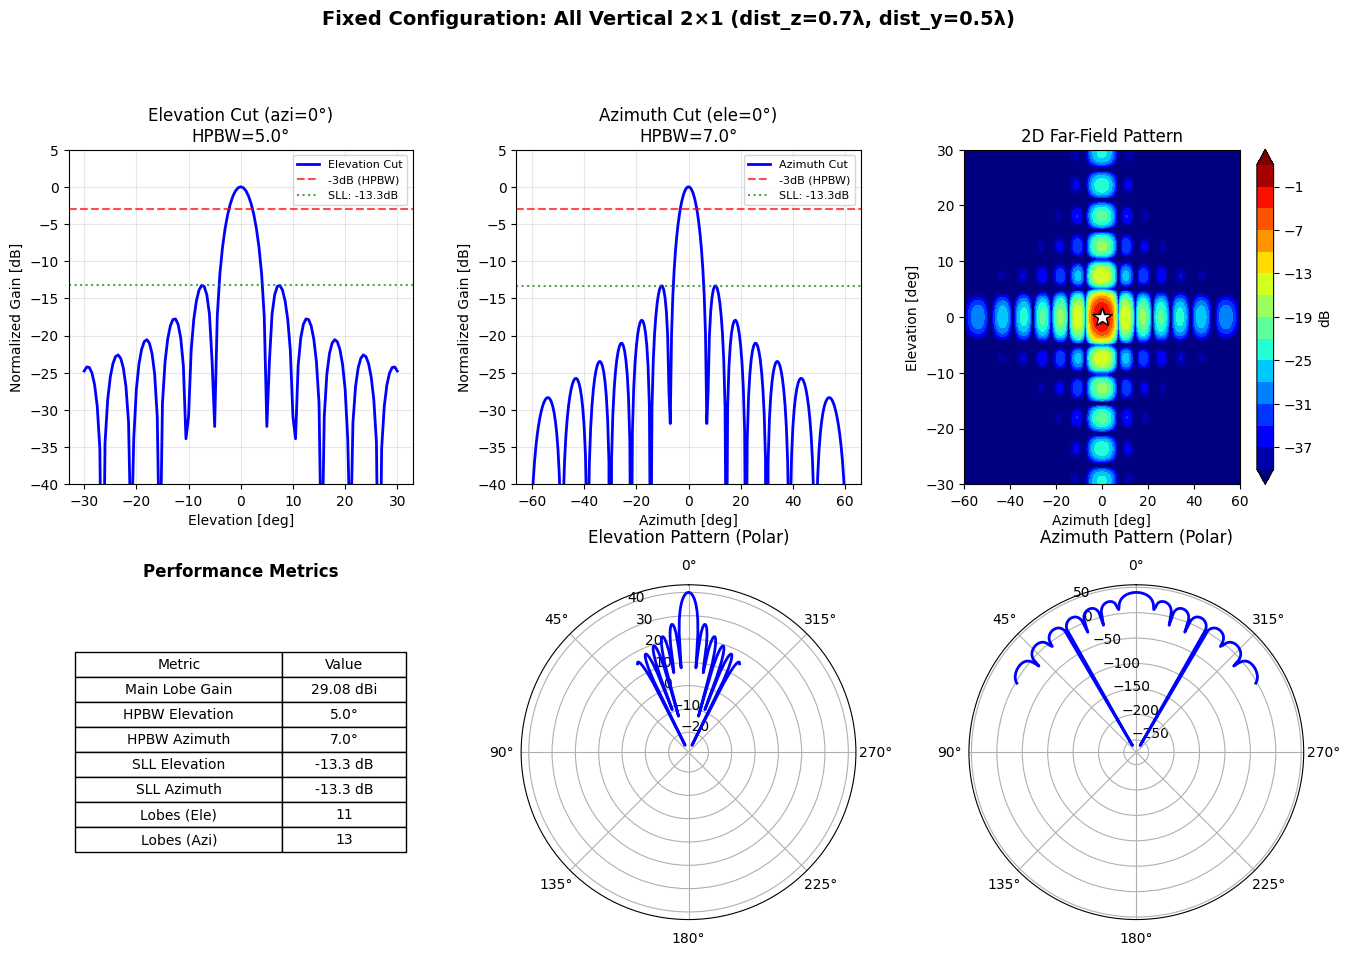

In [11]:
# ============================================================
# PLOT RISULTATI CONFIGURAZIONE FISSA
# ============================================================

print("="*70)
print("PLOT LOBE ANALYSIS - CONFIGURAZIONE FISSA (ALL VERTICAL 2x1)")
print("="*70)

fixed_metrics = plot_lobe_analysis(
    result_fixed['FF_I_dB'], 
    array, 
    G_boresight=result_fixed['G_boresight'],
    title=f'Fixed Configuration: All Vertical 2×1 (dist_z={lattice.dist_z}λ, dist_y={lattice.dist_y}λ)',
    save_path='../results_png/lobe_analysis_fixed_vertical2x1.png'
)

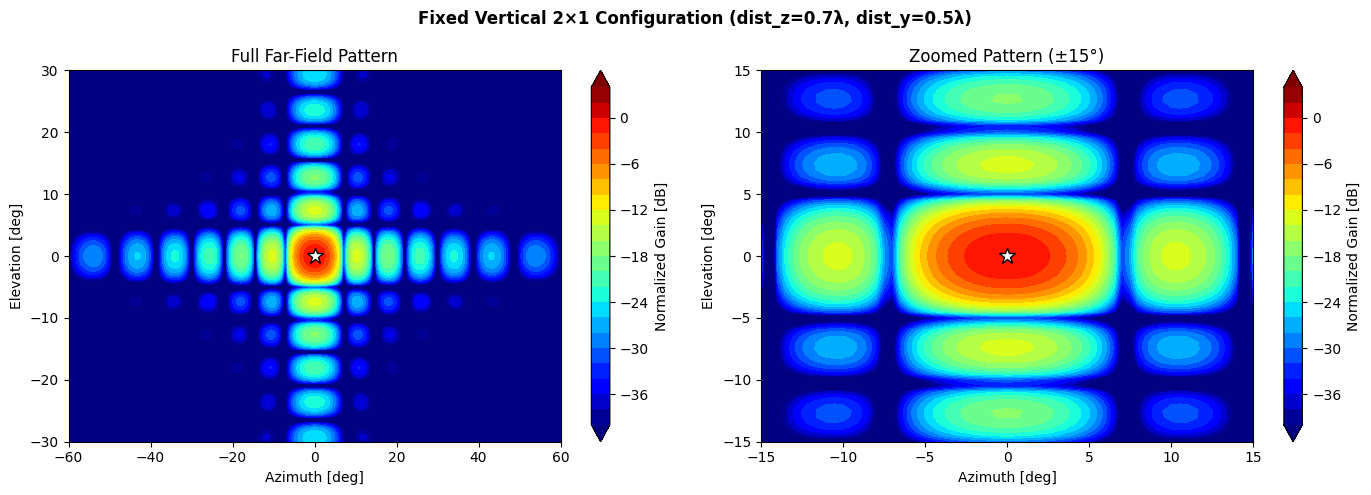

In [12]:
# ============================================================
# PLOT 2D PATTERN DETTAGLIATO
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Full pattern
levels = np.arange(-40, 5, 2)
c1 = axes[0].contourf(array.AZI, array.ELE, result_fixed['FF_I_dB'], 
                       levels=levels, cmap='jet', extend='both')
plt.colorbar(c1, ax=axes[0], label='Normalized Gain [dB]')
axes[0].set_xlabel('Azimuth [deg]')
axes[0].set_ylabel('Elevation [deg]')
axes[0].set_title('Full Far-Field Pattern')
axes[0].plot(0, 0, 'w*', markersize=12, markeredgecolor='k')

# Zoomed pattern around boresight
zoom_range = 15
azi_mask = (array.azi >= -zoom_range) & (array.azi <= zoom_range)
ele_mask = (array.ele >= -zoom_range) & (array.ele <= zoom_range)

AZI_zoom = array.AZI[np.ix_(ele_mask, azi_mask)]
ELE_zoom = array.ELE[np.ix_(ele_mask, azi_mask)]
FF_zoom = result_fixed['FF_I_dB'][np.ix_(ele_mask, azi_mask)]

c2 = axes[1].contourf(AZI_zoom, ELE_zoom, FF_zoom, 
                       levels=levels, cmap='jet', extend='both')
plt.colorbar(c2, ax=axes[1], label='Normalized Gain [dB]')
axes[1].set_xlabel('Azimuth [deg]')
axes[1].set_ylabel('Elevation [deg]')
axes[1].set_title(f'Zoomed Pattern (±{zoom_range}°)')
axes[1].plot(0, 0, 'w*', markersize=12, markeredgecolor='k')

plt.suptitle(f'Fixed Vertical 2×1 Configuration (dist_z={lattice.dist_z}λ, dist_y={lattice.dist_y}λ)', 
             fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('../results_png/pattern_2d_fixed_vertical2x1.png', dpi=150, bbox_inches='tight')
plt.show()

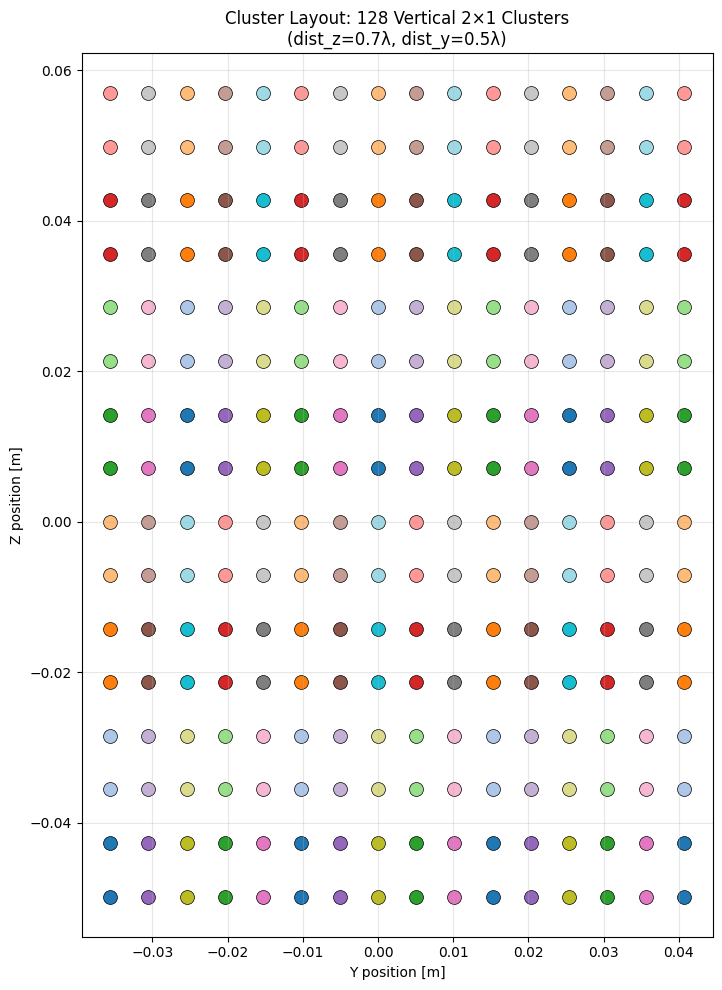

In [13]:
# ============================================================
# PLOT CLUSTER LAYOUT
# ============================================================

fig, ax = plt.subplots(figsize=(10, 10))

# Plot all antenna positions
ax.scatter(array.y_vec, array.z_vec, c='lightgray', s=50, alpha=0.5, label='Antenna elements')

# Plot clusters with colors
colors = plt.cm.tab20(np.linspace(0, 1, min(20, len(all_clusters_fixed))))
for i, cluster in enumerate(all_clusters_fixed):
    color = colors[i % len(colors)]
    for n_idx, m_idx in cluster:
        y_idx = np.where(array.NN[0, :] == n_idx)[0]
        z_idx = np.where(array.MM[:, 0] == m_idx)[0]
        if len(y_idx) > 0 and len(z_idx) > 0:
            y = array.Y[z_idx[0], y_idx[0]]
            z = array.Z[z_idx[0], y_idx[0]]
            ax.scatter(y, z, c=[color], s=100, edgecolors='black', linewidths=0.5)

ax.set_xlabel('Y position [m]')
ax.set_ylabel('Z position [m]')
ax.set_title(f'Cluster Layout: {len(all_clusters_fixed)} Vertical 2×1 Clusters\n(dist_z={lattice.dist_z}λ, dist_y={lattice.dist_y}λ)')
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results_png/cluster_layout_fixed_vertical2x1.png', dpi=150, bbox_inches='tight')
plt.show()

## Summary: Results for Team Lead

In [14]:
# ============================================================
# RIEPILOGO FINALE - RISULTATI PER TEAM LEAD
# ============================================================

print("\n" + "="*70)
print("RIEPILOGO FINALE - CONFIGURAZIONE FISSA VERTICAL 2x1")
print("="*70)
print()
print("CONFIGURAZIONE:")
print("-"*50)
print(f"  Array size:               {lattice.Nz} x {lattice.Ny} = {lattice.Nz * lattice.Ny} elementi")
print(f"  Distanza Z (verticale):   {lattice.dist_z}λ")
print(f"  Distanza Y (orizzontale): {lattice.dist_y}λ")
print(f"  Frequenza:                {system.freq/1e9:.1f} GHz")
print(f"  Lambda:                   {system.lambda_*1000:.2f} mm")
print(f"  Cluster type:             Vertical 2x1")
print(f"  Numero cluster:           {len(all_clusters_fixed)}")
print(f"  Elementi per cluster:     2")
print()
print("RISULTATI (da confrontare con teorico):")
print("-"*50)
print(f"  Cost Function (Cm):       {result_fixed['Cm']}")
print(f"  G_boresight:              {result_fixed['G_boresight']:.2f} dBi")
print(f"  SLL out FoV:              {result_fixed['sll_out']:.2f} dB")
print(f"  SLL in FoV:               {result_fixed['sll_in']:.2f} dB")
print(f"  HPBW Elevation:           {fixed_metrics['hpbw_ele']:.1f}°")
print(f"  HPBW Azimuth:             {fixed_metrics['hpbw_azi']:.1f}°")
print(f"  SLL Elevation (rel):      {fixed_metrics['sll_ele_relative']:.1f} dB")
print(f"  SLL Azimuth (rel):        {fixed_metrics['sll_azi_relative']:.1f} dB")
print(f"  Number of lobes (ele):    {fixed_metrics['n_lobes_ele']}")
print(f"  Number of lobes (azi):    {fixed_metrics['n_lobes_azi']}")
print(f"  Max pointing:             θ={result_fixed['theta_max']:.1f}°, φ={result_fixed['phi_max']:.1f}°")
print()
print("FILE SALVATI:")
print("-"*50)
print("  - lobe_analysis_fixed_vertical2x1.png")
print("  - pattern_2d_fixed_vertical2x1.png")
print("  - cluster_layout_fixed_vertical2x1.png")
print()
print("="*70)


RIEPILOGO FINALE - CONFIGURAZIONE FISSA VERTICAL 2x1

CONFIGURAZIONE:
--------------------------------------------------
  Array size:               16 x 16 = 256 elementi
  Distanza Z (verticale):   0.7λ
  Distanza Y (orizzontale): 0.5λ
  Frequenza:                29.5 GHz
  Lambda:                   10.17 mm
  Cluster type:             Vertical 2x1
  Numero cluster:           128
  Elementi per cluster:     2

RISULTATI (da confrontare con teorico):
--------------------------------------------------
  Cost Function (Cm):       7150
  G_boresight:              29.08 dBi
  SLL out FoV:              -13.32 dB
  SLL in FoV:               -3.08 dB
  HPBW Elevation:           5.0°
  HPBW Azimuth:             7.0°
  SLL Elevation (rel):      -13.3 dB
  SLL Azimuth (rel):        -13.3 dB
  Number of lobes (ele):    11
  Number of lobes (azi):    13
  Max pointing:             θ=0.0°, φ=0.0°

FILE SALVATI:
--------------------------------------------------
  - lobe_analysis_fixed_vertical2x1

In [15]:
# ============================================================
# SALVA RISULTATI IN JSON PER RIFERIMENTO
# ============================================================

import json

results_summary = {
    "configuration": {
        "array_size": f"{lattice.Nz}x{lattice.Ny}",
        "total_elements": lattice.Nz * lattice.Ny,
        "dist_z_lambda": lattice.dist_z,
        "dist_y_lambda": lattice.dist_y,
        "frequency_GHz": system.freq / 1e9,
        "lambda_mm": system.lambda_ * 1000,
        "cluster_type": "vertical_2x1",
        "num_clusters": len(all_clusters_fixed),
        "elements_per_cluster": 2,
    },
    "results": {
        "cost_function_Cm": int(result_fixed['Cm']),
        "G_boresight_dBi": float(result_fixed['G_boresight']),
        "SLL_out_FoV_dB": float(result_fixed['sll_out']),
        "SLL_in_FoV_dB": float(result_fixed['sll_in']),
        "HPBW_elevation_deg": float(fixed_metrics['hpbw_ele']),
        "HPBW_azimuth_deg": float(fixed_metrics['hpbw_azi']),
        "SLL_elevation_relative_dB": float(fixed_metrics['sll_ele_relative']),
        "SLL_azimuth_relative_dB": float(fixed_metrics['sll_azi_relative']),
        "num_lobes_elevation": int(fixed_metrics['n_lobes_ele']),
        "num_lobes_azimuth": int(fixed_metrics['n_lobes_azi']),
        "max_pointing_theta_deg": float(result_fixed['theta_max']),
        "max_pointing_phi_deg": float(result_fixed['phi_max']),
    }
}

with open("../results/results_fixed_vertical2x1.json", "w") as f:
    json.dump(results_summary, f, indent=2)

print("Risultati salvati in: ../results/results_fixed_vertical2x1.json")

Risultati salvati in: results_fixed_vertical2x1.json
